# Smoothing kernel

Consider a task kernel which only encodes the notion that all tasks are somewhat related:
$$
K(x, x') = \alpha + (1-\alpha)\delta(x, x')\,
$$
with $\delta(., .)$ the delta-kernel whose value is 1 if the arguments are equal and 0 otherwise. When $\alpha=0$ each task is independend (no leaking of the labels) and if it has the value 1, all tasks are equivalent.

We need the hat matrix, such that:
$$
\hat{\mathbf{Y}} = \mathbf{HY}\,.
$$

For kernel ridge regression with a regularization parameter $\lambda$, we can calculate this hat matrix without requirering a matrix inverse.

$$
\mathbf{H} = (\mathbf{1} \mathbf{1}^\intercal (1-\alpha) + (\alpha+\lambda)\mathbf{I})^{-1}(\mathbf{1} \mathbf{1}^\intercal (1-\alpha) + \alpha\mathbf{I})\\
=(\mathbf{1} \mathbf{1}^\intercal (1-\alpha) + (\alpha+\lambda)\mathbf{I})^{-1}\mathbf{1} \mathbf{1}^\intercal (1-\alpha) + (\mathbf{1} \mathbf{1}^\intercal (1-\alpha) + (\alpha+\lambda)\mathbf{I})^{-1}\alpha\mathbf{I}\\
= \frac{1}{\alpha+\lambda}\mathbf{I} + \mathbf{1}[\frac{1-\alpha}{\alpha}(\frac{N}{\alpha+\lambda} + \frac{1}{1-\alpha})^{-1} - \frac{\alpha}{(\alpha+\lambda)^2}(\frac{1}{\alpha+\lambda} + \frac{N}{1-\alpha})^{-1}]\mathbf{1}^\intercal\\
= \frac{\alpha}{\alpha+\lambda} \mathbf{I} + \mathbf{1} \mathbf{1}^\intercal\frac{\lambda(\alpha-1)}{(\alpha+\lambda)(N(\alpha-1)-\alpha -\lambda)}
$$

This derivation is based on the Woodbury identity, some simplifications are done below in Sympy.


# Derivation

In [1]:
import sympy as sp
sp.init_printing()

In [2]:
a, l, N = sp.symbols('alpha, lambda, N')

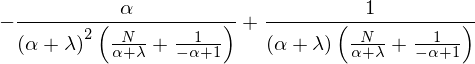

In [33]:
expr = 1/(a+l)/(N/(a+l) + 1/(1-a)) - a / (a + l)**2 /(N/(a+l) + 1/(1-a))
expr

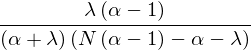

In [34]:
expr.simplify()

In [37]:
weights_smoothing = sp.lambdify((N, a, l), expr)

# Numerical tests

In [43]:
import numpy as np

def generate_hat_naive(N, alpha, lambd):
    return np.linalg.inv(np.ones((N, N))*(1.0-alpha) + (alpha + lambd) *\
            np.eye(N)).dot(np.ones((N, N))*(1.0-alpha) + (alpha) * np.eye(N))
    
def generate_hat_shortcut(N, alpha, lambd):
    return alpha/(alpha+lambd)*np.eye(N) + np.ones((N, N)) * weights_smoothing(N, alpha, lambd)

In [54]:
N_list=[10, 100, 1000]
alpha_list=np.linspace(0.1, 0.9, 9)
lambd_list=np.logspace(-5, 4, 10)
for alpha in alpha_list:
    for lambd in lambd_list:
        for N in N_list:
            the_same = np.allclose(generate_hat_shortcut(N, alpha, lambd), generate_hat_naive(N, alpha, lambd))
            assert the_same